In [1]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pycorrelate
import collections
import itertools
from mpl_toolkits import mplot3d
import cv2
import imutils
import os

pd.set_option('display.max_rows', 1000)
%matplotlib inline

### 1. Pick a session to work with!

In [2]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3b,  irmandy_1,  juliana_1,  irmandy_2,  patrick_3,  

In [3]:
SESSION = 'patrick_3'

let's print some basic summary statistics based on the metadata for this session:

In [4]:
s_meta = metadata[SESSION]

try:
    print(SESSION, 'on', s_meta['date'])
    print('-'*10)
    print(s_meta['glasses_sessions_total_duration_string'], 'hr of glassess data starting at', \
          s_meta['glasses_session_times'][0][0])
    print('%02d:%02d hr of    video data starting at ' % (s_meta['vid_duration_sec'] / 60 // 60, 
           s_meta['vid_duration_sec'] / 60 % 60 )  + s_meta['vid_start'])
    print('-'*10)
    print('glasses sessions:')
    for i in range(len(s_meta['glasses_session_times'])):
        print('session ' + str(i) + ':',s_meta['glasses_session_times'][i][0],'to',\
              s_meta['glasses_session_times'][i][1],'\tduration:%8.2f min' % s_meta['glasses_session_durations_min'][i])
except:
    print('failed to load video analysis file.')

patrick_3 on 04/28
----------
04:25 hr of glassess data starting at 04/28/21 01:10:27PM EDT
04:26 hr of    video data starting at 04/28/21 01:10:00PM EDT
----------
glasses sessions:
session 0: 04/28/21 01:10:27PM EDT to 04/28/21 05:35:58PM EDT 	duration:  265.52 min


### Load the Data
...and let's load in the data, and plot what we have just to take a look, by session

In [5]:
#load video data (eyeratio and openface features), 60 Hz (16 ms between samples)
df_vid = pd.read_csv('./cleaned_data/' + SESSION + '/video_consolidated.csv', index_col=0)

#load glasses blink data, 1kHz (1 ms between samples)
blink_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_blink.p', 'rb'))

#load glasses accel data, 10 Hz (100 ms between samples)
accel_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_accel.p', 'rb'))

# give some stupid FutureWarning error thanks to pandas and numpy not being in sync.
# https://stackoverflow.com/questions/48818335/why-pandas-read-csv-issues-this-warning-elementwise-comparison-failed

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df_vid.head()

,index_x,eye_ratio,index_y,AU45_r,AU45_c,pose_Rx,pose_Ry,pose_Rz,pose_Tx,pose_Ty,pose_Tz,success,confidence,tick_ms,est_timestamp_ms
0,0,NaN,0,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0,0,0.0,0,1619629800000
1,1,NaN,1,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0,0,0.0,17,1619629800017
2,2,NaN,2,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0,0,0.0,33,1619629800033
3,3,NaN,3,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0,0,0.0,50,1619629800050
4,4,NaN,4,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0,0,0.0,67,1619629800067


In [7]:
#STREAM A SECTION OF VIDEO WITH A DF OVERLAY OF BLINK TIMES

#show video with overlay of a df with timestamps and an offset so we can manually check blink alignment of both the video DF and our video analysis DF
#above we were aligning the video to the glasses; here we'll align our glasses to the video

#lets just do everything in minutes like we were doing in the above
def stream_with_blink_data_overlay(video_filename, frame_data, start_frame, end_frame):

    WINDOW_NAME = 'blink_window'
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
    cv2.startWindowThread()
    
    vs = cv2.VideoCapture(video_filename)
    vs.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    time.sleep(1.0)
    
    print(frame_data)
    
    blink_count, prev_frame = 0,0
    
    for fno in range(0, end_frame-start_frame):
        _, frame = vs.read()  
        
        if not fno:
            os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Python" to true' ''') 
    
        if frame_data[start_frame+fno] and not prev_frame:
            blink_count += 1
            
        
        cv2.putText(frame, "COUNT: %d"%(blink_count), (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
       
        if frame_data[start_frame+fno]:
            cv2.putText(frame, "BLINKING NOW!!!!!!", (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # show the frame
        cv2.imshow(WINDOW_NAME, frame)
        key = cv2.waitKey(1) & 0xFF

        prev_frame = frame_data[start_frame+fno]
        
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # do a bit of cleanup
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Chrome" to true' ''') 


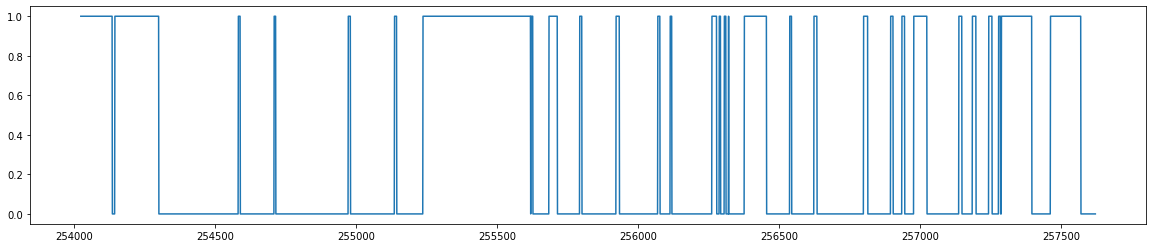

254023    1.0
254024    1.0
254025    1.0
254026    1.0
254027    1.0
         ... 
257618    0.0
257619    0.0
257620    0.0
257621    0.0
257622    0.0
Name: AU45_c, Length: 3600, dtype: float64


In [8]:
start_frame = 254023
dur_min = 1

fig, ax = plt.subplots(figsize=(20,4))
plt.plot(df_vid['AU45_c'].iloc[start_frame:start_frame+60*60*dur_min])
plt.show()

stream_with_blink_data_overlay('/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_crop_1.mp4',  #/openface/video_adobe.mp4
                               df_vid['AU45_c'].iloc[start_frame:start_frame+60*60*dur_min], 
                               start_frame, 
                               start_frame+60*60*dur_min) #one min


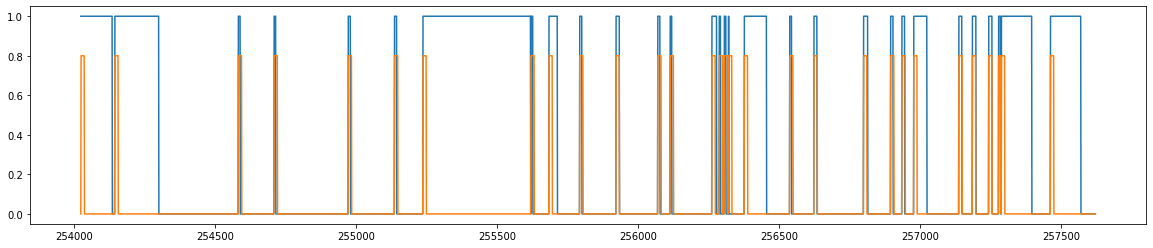

254023    0.0
254024    1.0
254025    1.0
254026    1.0
254027    1.0
         ... 
257618    0.0
257619    0.0
257620    0.0
257621    0.0
257622    0.0
Length: 3600, dtype: float64


In [9]:
#change it to rising edge and blink_dur
blinksig = df_vid['AU45_c'].iloc[start_frame:start_frame+60*60*dur_min].values
prev = 0

blink_dur_frames = 12

final_blinksig = np.zeros(len(blinksig))
for i in range(1, len(blinksig)):
    if blinksig[i] and not prev:
        final_blinksig[i-1] = 0
        
        if i+blink_dur_frames > len(blinksig):
            final_blinksig[i:-1] = 1
        else:
            final_blinksig[i:i+blink_dur_frames] = 1
        
    prev= blinksig[i]
        
df_final_blinksig = pd.Series(data=final_blinksig, index=range(start_frame,start_frame+60*60*dur_min))

df_final_blinksig[254023]
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(df_vid['AU45_c'].iloc[start_frame:start_frame+60*60*dur_min])
plt.plot(df_final_blinksig*.8)
plt.show()


stream_with_blink_data_overlay('/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_crop_1.mp4',  #/openface/video_adobe.mp4
                               df_final_blinksig, 
                               start_frame, 
                               start_frame+60*60*dur_min) #one min


In [12]:
print(df_vid.iloc[start_frame])
print(df_vid['est_timestamp_ms'].iloc[0])

index_x                     14571
eye_ratio                0.002575
index_y                    254023
AU45_r                       1.07
AU45_c                        1.0
pose_Rx                    -0.104
pose_Ry                       0.3
pose_Rz                    -0.124
pose_Tx                      14.0
pose_Ty                      -8.8
pose_Tz                     499.9
success                         1
confidence                   0.98
tick_ms                   4237950
est_timestamp_ms    1619634037950
Name: 254023, dtype: object
1619629800000


In [ ]:
#the above starts at timestamp 1619634037950
#the vid starttime is timestamp 1619629800000
#it lasts one min, and uses a blink duration of 0.2s

In [2]:
#something is amiss with our other code -- the timing is off significantly
#does this have to do with using timestamps instead of frame indices?

fps = 60
start_time = 1619629800000
frame_num = 254023
print('frame time is 1619634037950 based on what we\'ve saved')
print('frame time should be:', start_time+(frame_num/60*1000), 'based on calculated frame number')
print('difference of ', 1619634037950 - (start_time+(frame_num/60*1000)))

frame time is 1619634037950 based on what we've saved
frame time should be: 1619634033716.6667 based on calculated frame number
difference of  4233.333251953125


In [3]:
#what is the effective sample rate if we trust the timestamps instead of using FPS?
print('effective FPS based on the timestamp:', frame_num/((1619634037950-start_time)/1000))

effective FPS based on the timestamp: 59.94006536179049


In [4]:
#F**k me the actual framerate is 59.94

fps = 59.94
start_time = 1619629800000
frame_num = 254023
print('frame time is 1619634037950 based on what we\'ve saved')
print('frame time should be:', start_time+(frame_num/fps*1000), 'based on calculated frame number')
print('difference of ', 1619634037950 - (start_time+(frame_num/fps*1000)))


frame time is 1619634037950 based on what we've saved
frame time should be: 1619634037954.6213 based on calculated frame number
difference of  -4.621337890625
